In [ ]:
# default_exp bgseg_unet_training

In [25]:
from facelib.bgseg_dataset_coco import out_path_lbl as path_lbl, out_path_img as path_img
path_lbl, path_img

(PosixPath('../data/seg/coco/labels'), PosixPath('../data/seg/coco/images'))

In [26]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from pathlib import PosixPath

In [3]:
fnames = get_image_files(path_img)
fnames[:3], len(fnames)

([PosixPath('../data/seg/coco/images/000000395203.jpg'),
  PosixPath('../data/seg/coco/images/000000118447.jpg'),
  PosixPath('../data/seg/coco/images/000000196483.jpg')],
 8764)

In [4]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('../data/seg/coco/labels/000000536743.png'),
 PosixPath('../data/seg/coco/labels/000000265810.png'),
 PosixPath('../data/seg/coco/labels/000000004134.png')]

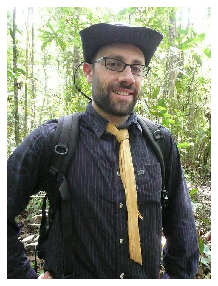

In [5]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [6]:
get_y_fn = lambda x: path_lbl/f'{x.stem}.png'

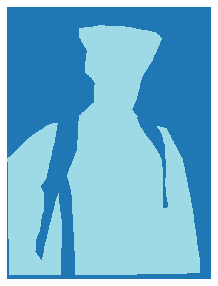

In [7]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [8]:
src_size = np.array(mask.shape[1:])
src_size,mask.data.unique()

(array([640, 480]), tensor([0, 1]))

In [9]:
src_size = np.array([512, 512])

In [10]:
codes = ['bg', 'person']

In [11]:
len(codes)

2

In [12]:
train_transforms = [
    dihedral_affine(),
    rotate(degrees=(-45, 45), p=0.5),
    symmetric_warp(magnitude=(-0.3, 0.3), p=0.6),
    rand_zoom(scale=(1.,2.), p=0.8),
    brightness(change=(0.3, 0.7), p=0.6),
    contrast(scale=(0.7,1.3), p=0.6),
    rand_crop(padding_mode='zeros')
]
valid_transforms = [
]

custom_transforms = (train_transforms,valid_transforms)

In [13]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct(0.1)
       .label_from_func(get_y_fn, classes=codes))

def create_data(size=[720,960], bs=4):
    data = (src
           .transform(get_transforms(), size=size, tfm_y=True)
           .databunch(bs=bs)
           .normalize(imagenet_stats)
          )
    return data

In [ ]:
size = src_size//8
data = create_data(size, bs=8)
size

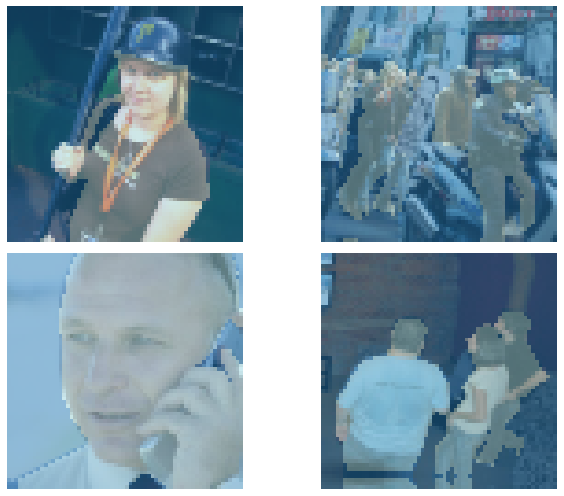

In [15]:
data.show_batch(2, figsize=(10,7))

In [16]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['bg']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [23]:
def save_learner(learn, name):
    learn.path = PosixPath('../models/')
    learn.metrics = []
    learn.export(name)
    learn.path = path_img
    learn.metrics = [acc_camvid]
    
def load_my_learner(name):
    learn = load_learner('../models/', file=name)
    learn.metrics = [acc_camvid]
    learn.path = path_img
    return learn

In [ ]:
size = src_size//8
data = create_data(size, bs=8)

In [21]:
learn = unet_learner(data, models.resnet34, metrics=[acc_camvid], wd=1e-3)
learn.callbacks.append(ShowGraph(learn))

In [31]:
learn = load_my_learner('bgseg_unet.pkl')
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


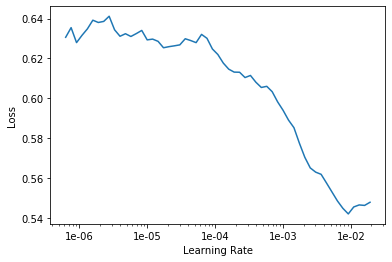

In [32]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
learn = load_learner('../models/', file='bgseg_unet.pkl')

epoch,train_loss,valid_loss,acc_camvid,time
0,0.422567,0.399405,0.907125,00:36
1,0.392834,0.376209,0.823929,00:36
2,0.353990,0.367377,0.803814,00:36
3,0.352939,0.339099,0.878305,00:36
4,0.342865,0.328865,0.885885,00:37
5,0.327126,0.324820,0.898142,00:36
6,0.317465,0.313945,0.860976,00:37
7,0.298272,0.307903,0.903736,00:37
8,0.293616,0.305045,0.880839,00:37
9,0.282676,0.304618,0.894020,00:37


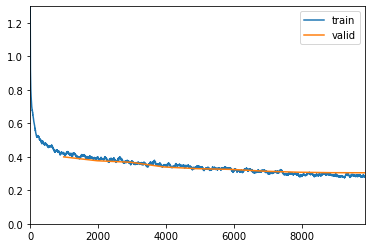

In [33]:
learn.fit_one_cycle(10, 1e-3)

In [34]:
size = src_size
learn.data = create_data(size, bs=4)
size

array([512, 512])

In [36]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.188622,0.191517,0.938296,02:34
1,0.203185,0.199371,0.922445,02:37
2,0.211287,0.206087,0.935467,02:38
3,0.199205,0.207237,0.933544,02:38


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



epoch,train_loss,valid_loss,acc_camvid,time
0,0.245954,0.237487,0.923287,03:09
1,0.237489,0.235646,0.937002,03:05
2,0.226826,0.219658,0.913595,03:05
3,0.224103,0.217514,0.919271,03:05
4,0.223086,0.216938,0.922318,03:05


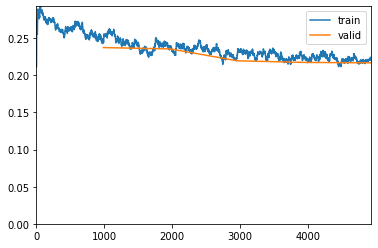

In [22]:
learn.fit_one_cycle(5, 1e-4)

In [23]:
save_learner(learn, 'bgseg_unet.pkl')

In [38]:
size = src_size//2
learn.data = create_data(size, bs=4)
size

array([384, 384])

epoch,train_loss,valid_loss,acc_camvid,time
0,0.230143,0.201994,0.949485,09:45
1,0.234515,0.194666,0.925286,09:45
2,0.210389,0.190197,0.910677,09:46


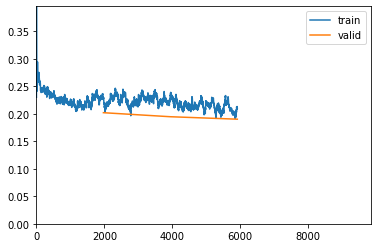

RuntimeError: DataLoader worker (pid 15899) is killed by signal: Segmentation fault. 

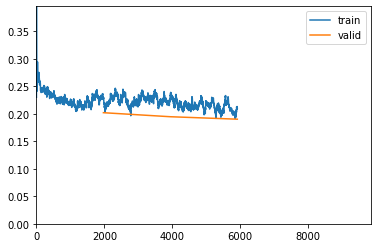

In [39]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.238922,0.220181,0.932507,11:38
1,0.231909,0.212864,0.934148,11:34
2,0.217465,0.206241,0.928218,11:35


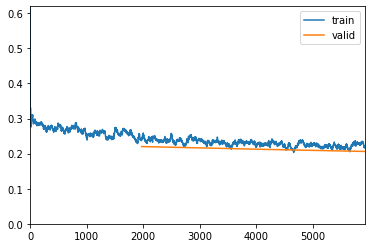

In [25]:
learn.fit_one_cycle(3, 1e-4)

In [40]:
save_learner(learn, 'bgseg_unet.pkl')

In [41]:
learn.unfreeze()
learn.wd = 1e-2
learn.fit_one_cycle(10, slice(1e-3))

epoch,train_loss,valid_loss,acc_camvid,time


RuntimeError: CUDA out of memory. Tried to allocate 224.00 MiB (GPU 0; 7.80 GiB total capacity; 2.89 GiB already allocated; 76.00 MiB free; 499.19 MiB cached)

[[tensor(0.9298)],
 [tensor(0.9357)],
 [tensor(0.9324)],
 [tensor(0.9350)],
 [tensor(0.9370)]]

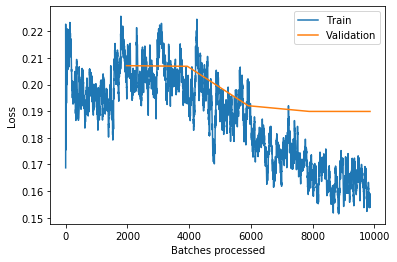

In [35]:
learn.recorder.plot_losses()
learn.recorder.metrics

In [36]:
save_learner(learn, 'bgseg_unet.pkl')

In [ ]:
size = (src_size//1.5).astype(int)
learn.data = create_data(size, bs=4)
size

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5,1e-4))

In [ ]:
save_learner(learn, 'bgseg_unet.pkl')

In [58]:
learn.unfreeze()

epoch,train_loss,valid_loss,acc_camvid,time
0,0.229119,0.212307,0.913366,15:16
1,0.221309,0.200527,0.923168,15:19
2,0.188710,0.191091,0.928361,15:19


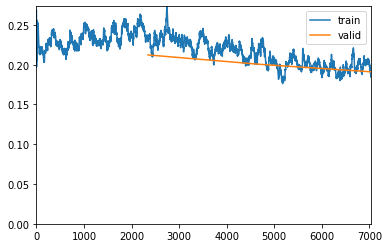

In [59]:
learn.fit_one_cycle(3, slice(lr))

In [60]:
save_learner(learn, 'unet.pkl')

epoch,train_loss,valid_loss,acc_camvid,time
0,0.196064,0.190569,0.933693,15:19
1,0.196038,0.189085,0.933552,15:20
2,0.184765,0.189209,0.936718,15:21


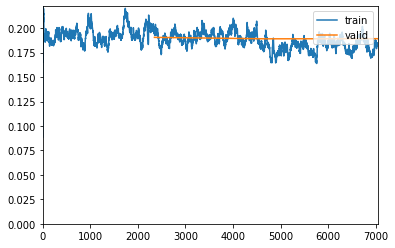

In [62]:
learn.fit_one_cycle(3, lr/10)

In [63]:
save_learner(learn, 'unet.pkl')

In [23]:
learn = load_learner('models/', file='unet.pkl')

### Convert images to masks

In [46]:
import cv2
from facelib.face_dataset_unlabeled import create_df as create_unlabeled_df

In [50]:
df = create_unlabeled_df()
df.head()

NameError: name 'dh' is not defined

In [43]:
defaults.device = torch.device('cuda')
learn = load_learner('../models/', file='bgseg_unet.pkl')
# _ = learn.model.to('cpu')

In [44]:
def im2mask(im):
    orig_shape = im.shape
    im = tensor(im[:,:,[2,1,0]]) #.to('cuda')

    im_res = F.interpolate(im.permute(2,0,1)[None].float(), size=(480,640))[0] / 255.
    image_res = Image(im_res)

    seg, *o = learn.predict(image_res)
    # mask = seg.data.float() # (only 0 or 1)
    mask = o[1][1][None] # [1,480,640]
    resize_one_img = lambda x, size: F.interpolate(x[None], size=size, mode='bilinear', align_corners=True)[0]
    mask = resize_one_img(mask.float(), orig_shape[:2])
    return Image(mask)

In [69]:
OUT_MASK_DIR = Path('../data/seg/unlabeled/')
IN_IMG_DIR = Path('/data/faces/unlabeled/images/')
def convert():
#     im_paths = get_image_files(IN_IMG_DIR)
    im_paths = list(df['image_path'])
    print('num images:', len(im_paths))
    for im_path in progress_bar(im_paths):
        im_name = Path(im_path).stem + '.png'
        im = cv2.imread(im_path)
        im2mask(im).save(OUT_MASK_DIR/im_name)
convert()

num images: 86130


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [70]:
1

1

In [64]:
im_paths = list(df['image_path'])
im_paths[:10]

['/data/faces/unlabeled/images/sof_1.jpg',
 '/data/faces/unlabeled/images/sof_724.jpg',
 '/data/faces/unlabeled/images/sof_404.jpg',
 '/data/faces/unlabeled/images/sof_1277.jpg',
 '/data/faces/unlabeled/images/sof_2491.jpg',
 '/data/faces/unlabeled/images/sof_1276.jpg',
 '/data/faces/unlabeled/images/sof_0.jpg',
 '/data/faces/unlabeled/images/sof_1897.jpg',
 '/data/faces/unlabeled/images/sof_10.jpg',
 '/data/faces/unlabeled/images/sof_725.jpg']

In [63]:
cv2.imread(str(IN_IMG_DIR/'fc_53099.png'))

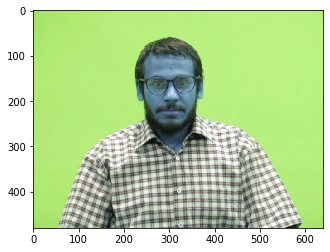

In [65]:
plot(cv2.imread(str(IN_IMG_DIR/'sof_1.jpg')))

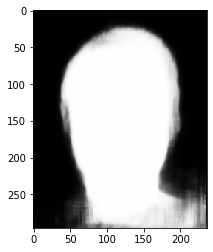

In [67]:
plot(cv2.imread(str(OUT_MASK_DIR/'sof_1.png')))

(296, 236, 3) torch.Size([1, 296, 236])


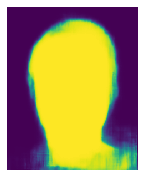

In [40]:
im = cv2.imread('../test_data/Face629.jpg')
im2mask(im).save('../test_data/temp.jpg')
im2mask(im).show()
print(im.shape, im2mask(im).shape)

### Examples

In [ ]:
learn = load_learner('../models/', file='bgseg_unet.pkl')

In [19]:
import cv2

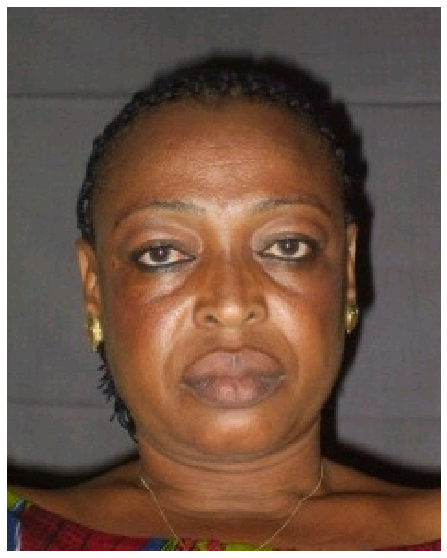

In [29]:
# im = cv2.imread('../test_data/newfam.jpg')
im = cv2.imread('../test_data/Face629.jpg')
im = im[:,:,[2,1,0]]
image = Image(tensor(im).permute(2,0,1).float() / 255.)
image.show(figsize=(10,10))

In [60]:
import matplotlib.pyplot as plt

def plot(im):
    ax = plt.figure()
    if len(im.squeeze().shape) == 2: plt.imshow(im, cmap='gray')
    else: plt.imshow(im)
    return plt.show()

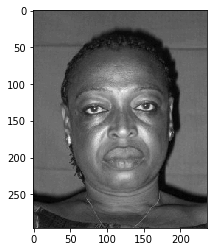

In [31]:
im_gray = cv2.cvtColor(to_np(image.data.permute(1,2,0)), cv2.COLOR_BGR2GRAY)
plot(im_gray)

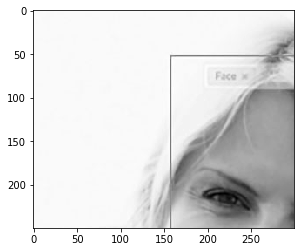

In [25]:
hair = im_gray[200:450 , 300:600]
plot(hair)

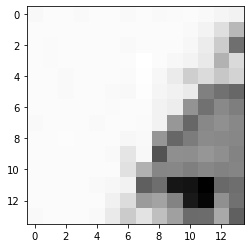

In [34]:
h = cv2.resize(hair, (14,14))
plot(h)

In [35]:
print(tensor(h*255).long())

tensor([[247, 250, 250, 249, 250, 250, 249, 250, 249, 249, 250, 249, 245, 243],
        [250, 250, 250, 250, 249, 250, 250, 250, 250, 250, 248, 244, 229, 199],
        [250, 249, 250, 250, 250, 250, 249, 250, 250, 250, 247, 238, 214, 143],
        [250, 249, 250, 250, 250, 250, 250, 253, 250, 247, 245, 236, 194, 225],
        [250, 250, 249, 250, 250, 250, 249, 252, 247, 237, 215, 225, 210, 219],
        [250, 250, 249, 250, 250, 249, 248, 252, 246, 242, 237, 156, 144, 137],
        [250, 250, 250, 250, 250, 249, 250, 250, 243, 239, 171, 146, 163, 155],
        [249, 250, 250, 250, 249, 250, 250, 249, 243, 174, 137, 162, 168, 162],
        [250, 250, 250, 250, 250, 250, 247, 248, 173, 137, 153, 164, 163, 161],
        [250, 250, 250, 250, 250, 249, 233, 248, 122, 168, 167, 173, 168, 158],
        [250, 250, 250, 250, 250, 250, 230, 193, 160, 161, 156, 161, 158, 160],
        [250, 250, 250, 250, 249, 247, 243, 131, 143,  75,  73,  58, 139, 142],
        [250, 250, 250, 250, 250, 242, 2

In [40]:
seg, *o = learn.predict(image)
seg.data.shape

torch.Size([1, 480, 640])

In [51]:
_[1].shape

torch.Size([2, 480, 640])

In [65]:
_[1][1].shape

torch.Size([480, 640])

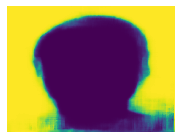

In [59]:
Image(_[1][0][None]).show()

In [68]:
im_res = F.interpolate(tensor(im).permute(2,0,1)[None].float(), size=(480,640))[0] / 255.
image_res = Image(im_res)

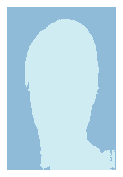

In [69]:
seg, *_ = learn.predict(image_res)
mask = seg.data.float() # (only 0 or 1)
# mask = o[1][1] # [480,640]
resize_one_img = lambda x, size: F.interpolate(x[None], size=size, mode='bilinear', align_corners=True)[0]
mask = resize_one_img(seg.data.float(), (600,400))
ImageSegment(mask).show()

In [35]:
seg, *_ = learn.predict(image_res)
seg.data.shape

torch.Size([1, 480, 640])

In [36]:
image_res.data.shape, seg.data.shape

(torch.Size([3, 480, 640]), torch.Size([1, 480, 640]))

In [37]:
m = seg.data
resize_one_img = lambda x, size: F.interpolate(x[None], size=size, mode='bilinear', align_corners=True)[0]
m_res = resize_one_img(m.float(), image_res.data.shape[1:])

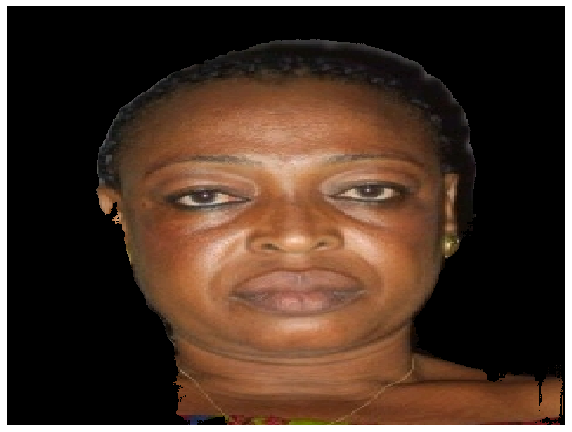

In [38]:
image_res.data[m_res.expand_as(image_res.data) != 1] = 0
image_res.show(figsize=(10,10))

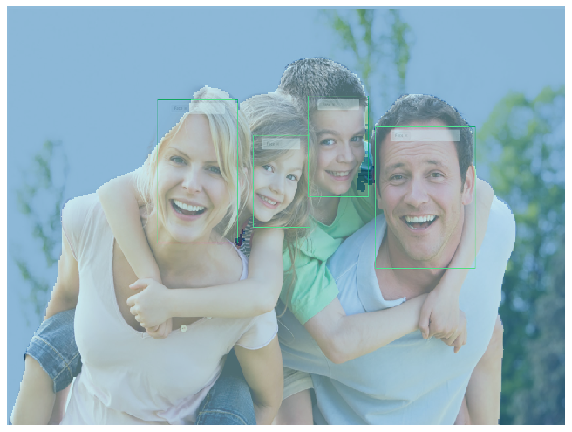

In [77]:
im_res = F.interpolate(tensor(im).permute(2,0,1)[None].float(), size=(480,640))[0] / 255.
Image(im_res).show(figsize=(10,10), y=ImageSegment(m_res))

In [ ]:
# learn.model

# Face Seg

In [ ]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

In [ ]:
# learn.load('stage-2')

In [ ]:
from pathlib import PosixPath
path = PosixPath('data/FASSEG/')
path_img = path/'images'
path_lbl = path/'labels'

In [ ]:
fnames = get_image_files(path_img)
fnames[:3]

In [ ]:
label_range = slice(0,227)

In [ ]:
camvid_codes = ['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall']

In [ ]:
camvid_codes.index('Sky'), camvid_codes.index('Pedestrian')

In [ ]:
# codes = ['eyes','hair','bg','mouth','nose','skin','contour']
codes = []
# 0-36: eyes
# 37: hair
# 76: bg
# 149: mouth
# 178: nose
# 225: face
# 38-75: contour
# 179-224: contour
# 77-148: contour
# 150-177: contour
# lbl_cats = [32,33,34,35,36,37,38,38,38,38,38]
lbl_cats = [16,16,21,16,16,16,16,16,16,16,16]
# lbl_cats = [0,1,2,3,4,5,6,6,6,6,6]
# lbl_cats = [0,1,2,3,3,3,4,4,4,4,4]

In [ ]:
def put_if_in_range(i, min_i, max_i, int2class, class_idx):
    if min_i <= i and i <= max_i:
        int2class[i] = class_idx
        
lbl2class = {}
for i in range(label_range.start, label_range.stop):
    put_if_in_range(i, 0, 36, lbl2class, lbl_cats[0]) # eyes
    put_if_in_range(i, 37, 37, lbl2class, lbl_cats[1]) # hair
    put_if_in_range(i, 76, 76, lbl2class, lbl_cats[2]) # bg
    put_if_in_range(i, 149, 149, lbl2class, lbl_cats[3]) # mouth
    put_if_in_range(i, 178, 178, lbl2class, lbl_cats[4]) # nose
    put_if_in_range(i, 225, 225, lbl2class, lbl_cats[5]) # skin
    put_if_in_range(i, 38, 75, lbl2class, lbl_cats[6]) # contour
    put_if_in_range(i, 77, 148, lbl2class, lbl_cats[7]) # contour
    put_if_in_range(i, 150, 177, lbl2class, lbl_cats[8]) # contour
    put_if_in_range(i, 179, 224, lbl2class, lbl_cats[9]) # contour
    put_if_in_range(i, 226, 226, lbl2class, lbl_cats[10]) # contour

In [ ]:
from tqdm.notebook import tqdm

def preprocess_masks(lbl_fnames, lbl_out_dir, label_range=label_range, lbl2class=lbl2class):
    for mpath in tqdm(lbl_fnames):
        m = open_mask(mpath).data
        res = m.clone()
        for i in range(label_range.start, label_range.stop):
            res[ m==i ] = lbl2class[i]
        seg = ImageSegment(res)
        seg.save(os.path.join(lbl_out_dir, f'{mpath.stem}_P{mpath.suffix}'))

In [ ]:
preprocess_masks(get_image_files('data/FASSEG/V2/labels'), path_lbl)

In [ ]:
codes = camvid_codes + codes
lbl_cats = list(range(0,32)) + lbl_cats

In [ ]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

In [ ]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [ ]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [ ]:
# for lb_path in lbl_names:
#     assert mask.data.min() == 0
#     assert mask.data.max() == len(codes)-1

In [ ]:
src_size = np.array([720, 960])
size = src_size//4

bs = 4

src = (SegmentationItemList.from_folder(path_img)
#        .split_by_rand_pct(0.2)
       .split_none()
       .label_from_func(get_y_fn, classes=codes))

data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
data.show_batch(2, figsize=(10,7))

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

metrics=acc_camvid

wd=1e-2

In [ ]:
# learn.save('fasseg-start')

In [ ]:
# learn.load('fasseg-start')

In [ ]:
learn.data = data

In [ ]:
learn.model.layers[-1]

In [ ]:
ni = 99
n_classes = len(codes)
len(codes)

In [ ]:
learn.model.layers[-1] = conv_layer(ni, n_classes, ks=1, use_activ=False, norm_type=None).to('cuda')

In [ ]:
learn.freeze_to(-1)

In [ ]:
def get_pred(y_pred, mask):
    y_pred0 = y_pred[:,0].unsqueeze(1)[mask].view(-1,1)
    y_pred1 = y_pred[:,1].unsqueeze(1)[mask].view(-1,1)
    y_pred = torch.cat((y_pred0, y_pred1), dim=1)
    return y_pred

# loss = CrossEntropyFlat()
loss = nn.CrossEntropyLoss()
def Loss(y_pred, y_true):
    b = y_pred.size(0)
    mask = (y_true != 0)
    num_fg = len(mask[0][mask[0]==True])
    y_pred_fg = get_pred(y_pred, mask)
    y_true_fg = y_true[mask].view(-1)
    mask = (y_true == 0)
    num_bg = len(mask[0][mask[0]==True])
    y_pred_bg = get_pred(y_pred, mask)
    y_true_bg = y_true[mask].view(-1)
    p = torch.randperm(y_true.size(-1)*y_true.size(-2))[:num_bg]
    y_pred = torch.cat((y_pred_fg, y_pred_bg[:,p]), dim=0)
    y_true = torch.cat((y_true_fg, y_true_bg[:,p]), dim=0)
    return loss(y_pred, y_true)
#     return loss(y_pred[mask.expand_as(y_pred)], y_true[mask].view(b,1,-1))

In [ ]:
# learn.loss_func = Loss

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(2, slice(1e-5), pct_start=0.8)

In [ ]:
learn.fit_one_cycle(10, slice(1e-5), pct_start=0.8)

In [ ]:
seg, *_ = learn.predict(image)
image.show(y=seg, figsize=(10,10))

In [ ]:
learn.fit_one_cycle(10, slice(1e-3), pct_start=0.8)

In [ ]:
# learn.show_results(rows=4, figsize=(8,9))

In [ ]:
seg, *_ = learn.predict(image)

In [ ]:
image.show(y=seg, figsize=(10,10))

In [ ]:
unique,counts = seg.data.unique(return_counts=True)
_,i = counts.sort()
print(unique[i])
print(counts[i])

In [ ]:
m = torch.zeros_like(seg.data)
m[seg.data == 16] = 1
face_seg = ImageSegment(m)
face_seg.show()

In [ ]:
resize_one_img = lambda x, size: F.interpolate(x[None], size=size, mode='bilinear', align_corners=True)[0]
m_res = resize_one_img(m.float(), image.data.shape[1:])

In [ ]:
image.data[m_res.expand_as(image.data) != 1] = 0
image.show(figsize=(10,10))

In [ ]:
image.show(figsize=(10,10))

# COCO

In [ ]:
asd

In [ ]:
path = untar_data(URLs.CAMVID)
path.ls()

# Big

In [ ]:
learn.destroy()

size = src_size

bs=2

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:

learn.fit_one_cycle(10, lrs)